Importing libraries

In [12]:
import pybammeis
import pybamm
import os
import re
import numpy as np
from gamry_parser import GamryParser, Impedance
import pandas as pd
import time as timer
import matplotlib.pyplot as plt
from scipy.fft import fft
import random
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from scipy.interpolate import interp1d
import pyswarms as ps 
from pyswarms.single import GlobalBestPSO

Uploading experimental data

In [16]:
# ved ca. 45% SoC 
# ved 25 deg C

def get_exp_data(i, d): 
    z_list = []
    file = "/Users/synnemard/Desktop/lithium_ion/EIS_data/MJ1_01_EIS-SoC_01-05/MJ1_01_EIS-SoC_0"+str(i)+"/"+d+"EISGALV3V587.DTA"
    ca = Impedance(file)
    ca.load(filename=file)

    # extract EIS curve
    res = ca.get_curve_data().iloc[::-1]
    df_real = res['Zreal']
    df_imag= res['Zimag']
    df_freq = res['Freq']
    #df_name = res['Vdc']

    # Removing the points beneath the y-axis 
    real = df_real[df_imag <= 0]
    imag = df_imag[df_imag <= 0]
    freq = df_freq[df_imag <= 0]
    
    #name = sum(df_name)/len(df_name)
    # Adding the impendances to the list 
    z_list.append(real)
    z_list.append(imag)
    return[z_list, freq] #, df_name]



Plotting

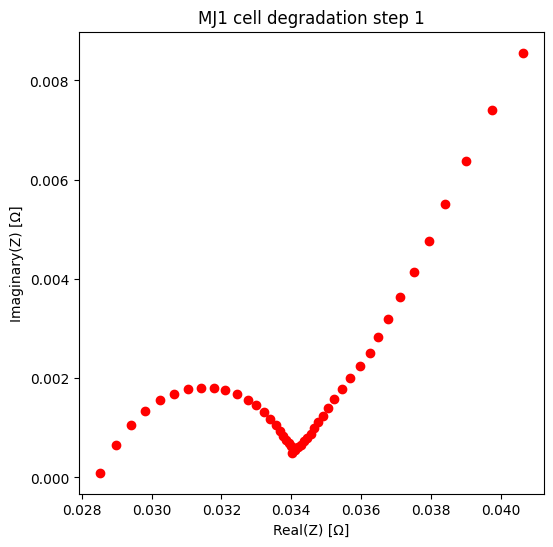

In [17]:
def plotting(i, d): 
    # Creating Nyquist plot
    plt.figure(figsize=(6,6))
    plt.scatter(get_exp_data(i, d)[0][0], -get_exp_data(i, d)[0][1], color='red') 

    # Labeling the plot
    plt.xlabel('Real(Z) [Ω]')
    plt.ylabel('Imaginary(Z) [Ω]')
    plt.title('MJ1 cell degradation step '+str(i))
    plt.show()

plotting(1, "")

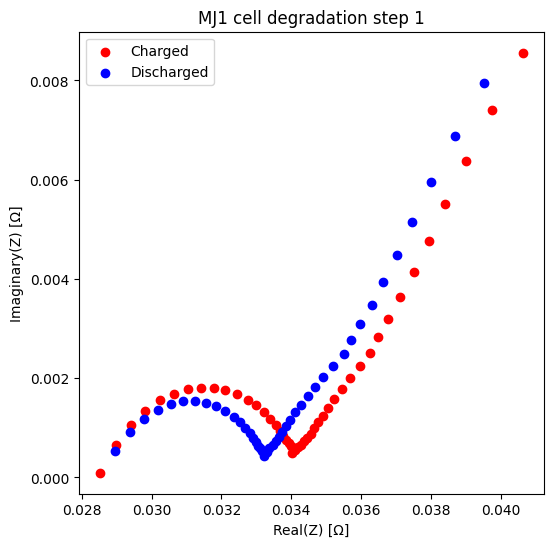

In [18]:
def combined_plot(i):
    # Creating the figure for both the charged and discharged data
    plt.figure(figsize=(6, 6))

    z_list_charged = get_exp_data(i, "")[0]
    z_list_discharged = get_exp_data(i, "d")[0]

    # Plot 
    plt.scatter(z_list_charged[0], -z_list_charged[1], color='red', label='Charged')
    plt.scatter(z_list_discharged[0], -z_list_discharged[1], color='blue', label='Discharged')

    # Adding labels and title
    plt.xlabel('Real(Z) [Ω]')
    plt.ylabel('Imaginary(Z) [Ω]')
    plt.title(f'MJ1 cell degradation step {i}')
    plt.legend()
    plt.show()

combined_plot(1)


Optimization of ECM parameters

In [19]:
# Randles components parameters 
c_elem = {
    "R_el": 0.026455095283510706,  # Electrolyte resistance (Ohms)
    "L": 5.534820787666664e-07, # Inductance (H)
    
    #Cathode? 
    "R_ct1": 0.0055426231465975665,  # Charge transfer resistance (Ohms)
    "Q1" : 0.6755099612832921, 
    "alpha1": 0.6624587164477784, 
    "A1": 0.0010503007445281985,     # Warburg coefficient
    "a_w1": 0.5722885441839765, 

    #Anode? 
    "R_ct2": 0.005384825939881047,  # Charge transfer resistance (Ohms)
    "Q2" : 2.339974970415867, 
    "alpha2": 0.8629910852751331, 
    "A2": 0.0011934570596558787,     # Warburg coefficient
    "a_w2": 0.5860161540205311, 
    }


# Function to convert dictionary to list
def dict_to_list(c_elem):
    return list(c_elem.values())

# Function to convert list back to dictionary
def list_to_dict(c_elem, optimized_values):
    keys = list(c_elem.keys())
    return dict(zip(keys, optimized_values))

# Define non-ideal Warburg impedance
def wni_imp(omega, A, a_w): # Non-Ideal 
    return A/(1j*omega)**a_w

# CPE for non-ideal behaviour
def cpe_imp(omega, Q, alpha): 
    return 1/(Q*(1j*omega)**alpha)

# Define Inductance impedance
def i_imp(omega, L): 
    return 1j*omega*L

In [83]:
# Function to calculate Z 
def calc_Z(comp, frequencies):
    # Update c_elem dictionary from the flat parameter list (comp)
    c_elem_up = list_to_dict(c_elem, comp)
    ang_freq = 2 * np.pi * frequencies

    Z_W1 = wni_imp(ang_freq, c_elem_up["A1"], c_elem_up["a_w1"])
    Z_cdl1 = cpe_imp(ang_freq, c_elem_up["Q1"], c_elem_up["alpha1"])
    Z_L = i_imp(ang_freq, c_elem_up["L"])

    Z_W2 = wni_imp(ang_freq, c_elem_up["A2"], c_elem_up["a_w2"])
    Z_cdl2 = cpe_imp(ang_freq, c_elem_up["Q2"], c_elem_up["alpha2"])
        
    # 1
    #Z1 =  1/(1/(c_elem_up["R_ct1"] + Z_W1) + 1/Z_cdl1)
    #Z2 =  0
    #Z = Z_L + c_elem_up["R_el"] + Z1 + Z2

    # 2 
    #Z1 =  1/(1/(c_elem_up["R_ct1"] + Z_W1) + 1/Z_cdl1)
    #Z2 =  1/(1/(c_elem_up["R_ct2"]) + 1/Z_cdl2)
    #Z = Z_L + c_elem_up["R_el"] + Z1 + Z2

    # 3 
    Z1 =  1/(1/(c_elem_up["R_ct1"] + Z_W1) + 1/Z_cdl1)
    Z2 =  1/(1/(c_elem_up["R_ct2"] + Z_W2) + 1/Z_cdl2)
    Z = Z_L + c_elem_up["R_el"] + Z1 + Z2

    return Z

# Optimizing the difference function for a given data set
def optimize_diff(i):
    # Load the experimental data 
    exp_real = np.array(get_exp_data(i, "")[0][0])
    exp_imag = np.array(get_exp_data(i, "")[0][1])
    frequencies = np.array(get_exp_data(i, "")[1])

    # Angular frequencies
    #ang_freq = 2 * np.pi * frequencies

    # Difference function for the optimization
    def diff_func(comp, exp_real, exp_imag):
        Z = calc_Z(comp, frequencies)
        diff_real = Z.real - exp_real
        diff_imag = Z.imag - exp_imag
        sum_square_diff = np.sum(diff_real ** 2 + diff_imag ** 2)
        return sum_square_diff

    # Convert initial dictionary to list for optimization
    initial_elems = dict_to_list(c_elem)

    # Optimization options
    options = {
        'maxiter': 10000,    # Maximum number of iterations
        'ftol': 1e-10,       # Function value tolerance
        #'disp': True
    }

    # Minimize the difference function (optimize parameters)
    opt = minimize(diff_func, initial_elems, args=(exp_real, exp_imag), method='TNC', options=options)
    opt_elems = list_to_dict(c_elem, opt.x)
    final_diff = diff_func(opt.x, exp_real, exp_imag)
    
    #print("Final sum of squared difference for dataset", i, ":", final_diff)

    return opt_elems, final_diff, frequencies, opt.x 

# Example usage: optimize for a specific dataset (choose i from 1 to 5)
i = 5 # Change i to the desired dataset index
dic_elems, final_diff, frequencies, list_elems = optimize_diff(i)
print(dic_elems)

diff1 = 7.661045025332906e-07 + 5.206179395934144e-06 + 9.578269123384994e-06 + 2.0128220759877942e-05 + 1.8415817063411835e-05
diff2 = 4.904406604759883e-07 + 1.7451590867924578e-06 + 1.7443521759186289e-06 + 2.6961066887229367e-06 + 3.2100672368715225e-06
diff3 = 5.035797885033441e-07 + 1.5383261261314162e-06 + 1.7991999141941941e-06 + 2.321400790810347e-06 + 2.635904538087328e-06
#print(diff1/5, diff2/5, diff3/5)

/var/folders/18/pf3m4tds5qs9rpymkqv73yxc0000gn/T/ipykernel_20543/572361733.py:60: OptimizeWarning: Unknown solver options: maxiter
  opt = minimize(diff_func, initial_elems, args=(exp_real, exp_imag), method='TNC', options=options)


{'R_el': 0.027472762627219805, 'L': 5.647382071687279e-07, 'R_ct1': 0.006077421674181444, 'Q1': 0.6857817825383884, 'alpha1': 0.6506570382522444, 'A1': 0.0011580195928436816, 'a_w1': 0.5747125829724442, 'R_ct2': 0.0055234876695869845, 'Q2': 2.4381386251593113, 'alpha2': 0.8563150596298102, 'A2': 0.0013705243028718775, 'a_w2': 0.5815568899296224}


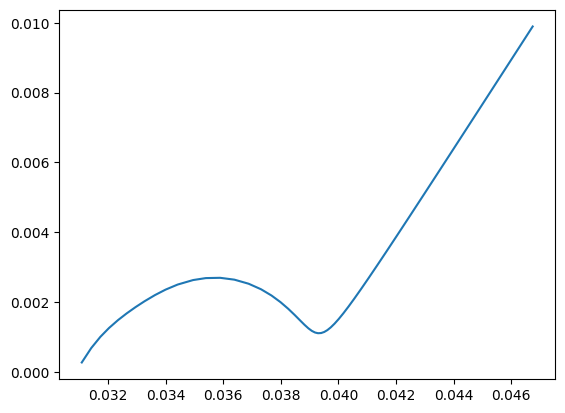

In [80]:
Z_randles = calc_Z(list_elems, frequencies)

plt.plot(Z_randles.real, -Z_randles.imag)
plt.show()

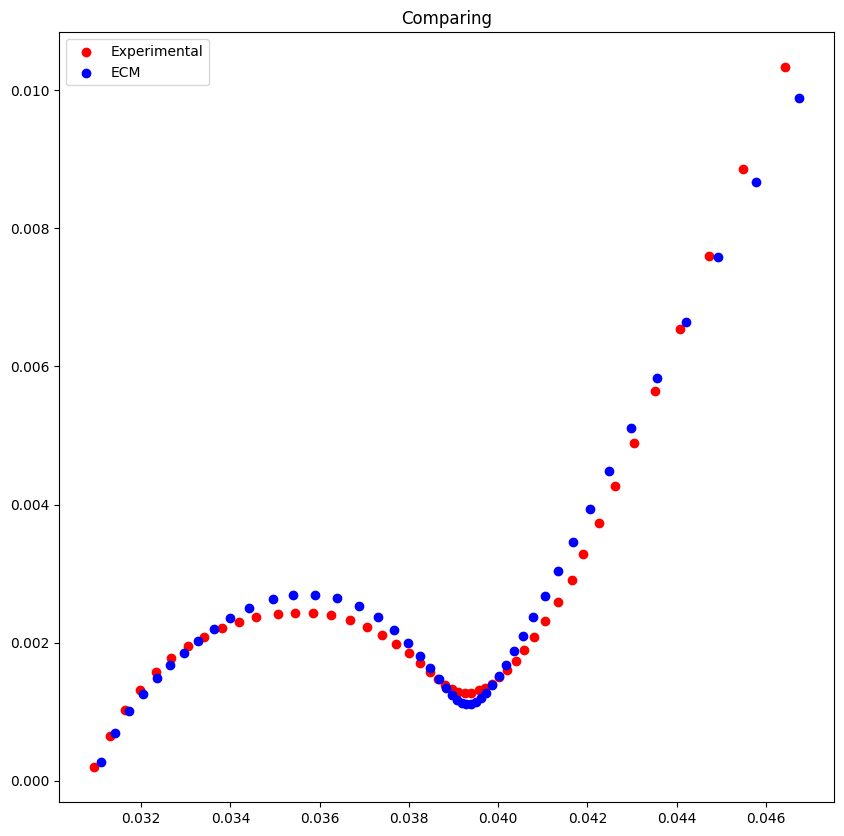

In [81]:
fig, ax = plt.subplots(figsize=(10, 10)) 
ax.scatter(np.array(get_exp_data(i, "")[0][0]), -np.array(get_exp_data(i, "")[0][1]), label=f"Experimental", color = 'red') 
ax.scatter(Z_randles.real, -Z_randles.imag, label = f'ECM', color = 'blue')

#ax.set_xlim(0.016, 0.045) 
#ax.set_ylim(0, 0.012)

plt.legend()
plt.title("Comparing") 
plt.show() 

Plotting ECM for all datasets in the same graph 

/var/folders/18/pf3m4tds5qs9rpymkqv73yxc0000gn/T/ipykernel_20543/572361733.py:60: OptimizeWarning: Unknown solver options: maxiter
  opt = minimize(diff_func, initial_elems, args=(exp_real, exp_imag), method='TNC', options=options)
/var/folders/18/pf3m4tds5qs9rpymkqv73yxc0000gn/T/ipykernel_20543/572361733.py:60: OptimizeWarning: Unknown solver options: maxiter
  opt = minimize(diff_func, initial_elems, args=(exp_real, exp_imag), method='TNC', options=options)
/var/folders/18/pf3m4tds5qs9rpymkqv73yxc0000gn/T/ipykernel_20543/572361733.py:60: OptimizeWarning: Unknown solver options: maxiter
  opt = minimize(diff_func, initial_elems, args=(exp_real, exp_imag), method='TNC', options=options)
/var/folders/18/pf3m4tds5qs9rpymkqv73yxc0000gn/T/ipykernel_20543/572361733.py:60: OptimizeWarning: Unknown solver options: maxiter
  opt = minimize(diff_func, initial_elems, args=(exp_real, exp_imag), method='TNC', options=options)
/var/folders/18/pf3m4tds5qs9rpymkqv73yxc0000gn/T/ipykernel_20543/5723617

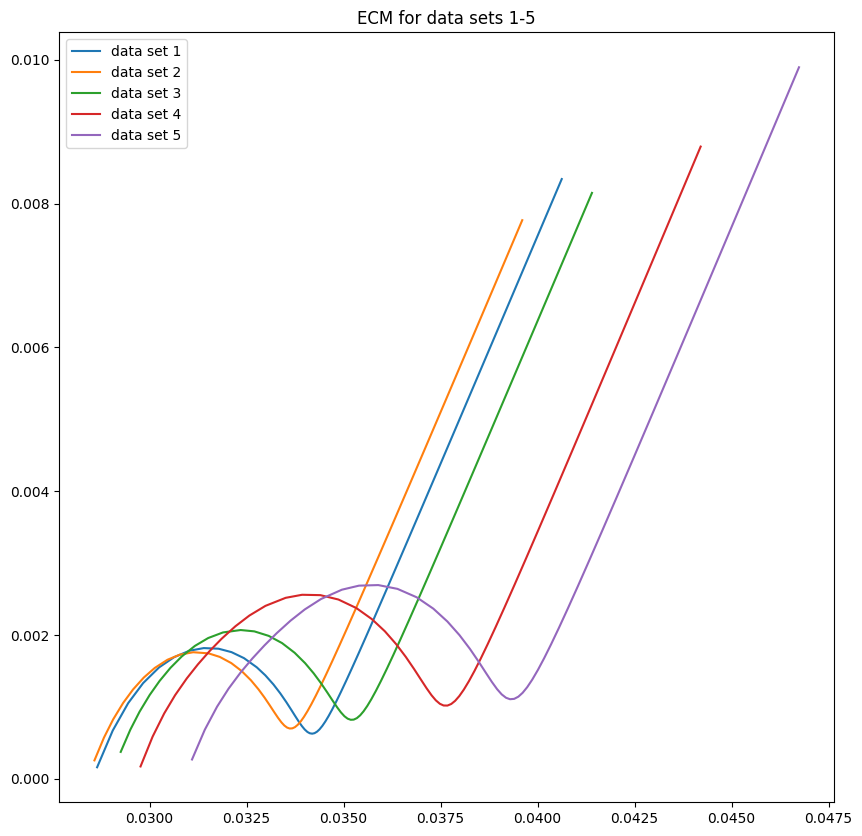

In [85]:
def plot_ECMs(): 
    fig, ax = plt.subplots(figsize=(10, 10)) 
    #ax.scatter(np.array(get_exp_data(i, "")[0][0]), -np.array(get_exp_data(i, "")[0][1]), label=f"Experimental", color = 'red') 
    for k in range(1, 6): 
        dic_elems, final_diff, frequencies, list_elems = optimize_diff(k)
        Z_randles = calc_Z(list_elems, frequencies)
        ax.plot(Z_randles.real, -Z_randles.imag, label = f'data set '+str(k))
    plt.legend()
    plt.title("ECM for data sets 1-5") 
    plt.show()

plot_ECMs()